Importing Libraries

In [64]:
# Import Libraries
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_theme()
%matplotlib inline

# Prevent warnings
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import keras
from scikeras.wrappers import KerasClassifier

In [65]:
# Dataset input
df = pd.read_csv("Indian Liver Patient Dataset (ILPD).csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        583 non-null    int64  
 1   Gender     583 non-null    object 
 2   TB         583 non-null    float64
 3   DB         583 non-null    float64
 4   Alkphos    583 non-null    int64  
 5   SGPT       583 non-null    int64  
 6   SGOT       583 non-null    int64  
 7   TP         583 non-null    float64
 8   ALB        583 non-null    float64
 9   A/G Ratio  579 non-null    float64
 10  Selector   583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [66]:
print(df.describe())

              Age          TB          DB      Alkphos         SGPT  \
count  583.000000  583.000000  583.000000   583.000000   583.000000   
mean    44.746141    3.298799    1.486106   290.576329    80.713551   
std     16.189833    6.209522    2.808498   242.937989   182.620356   
min      4.000000    0.400000    0.100000    63.000000    10.000000   
25%     33.000000    0.800000    0.200000   175.500000    23.000000   
50%     45.000000    1.000000    0.300000   208.000000    35.000000   
75%     58.000000    2.600000    1.300000   298.000000    60.500000   
max     90.000000   75.000000   19.700000  2110.000000  2000.000000   

              SGOT          TP         ALB   A/G Ratio    Selector  
count   583.000000  583.000000  583.000000  579.000000  583.000000  
mean    109.910806    6.483190    3.141852    0.947064    1.286449  
std     288.918529    1.085451    0.795519    0.319592    0.452490  
min      10.000000    2.700000    0.900000    0.300000    1.000000  
25%      25.000

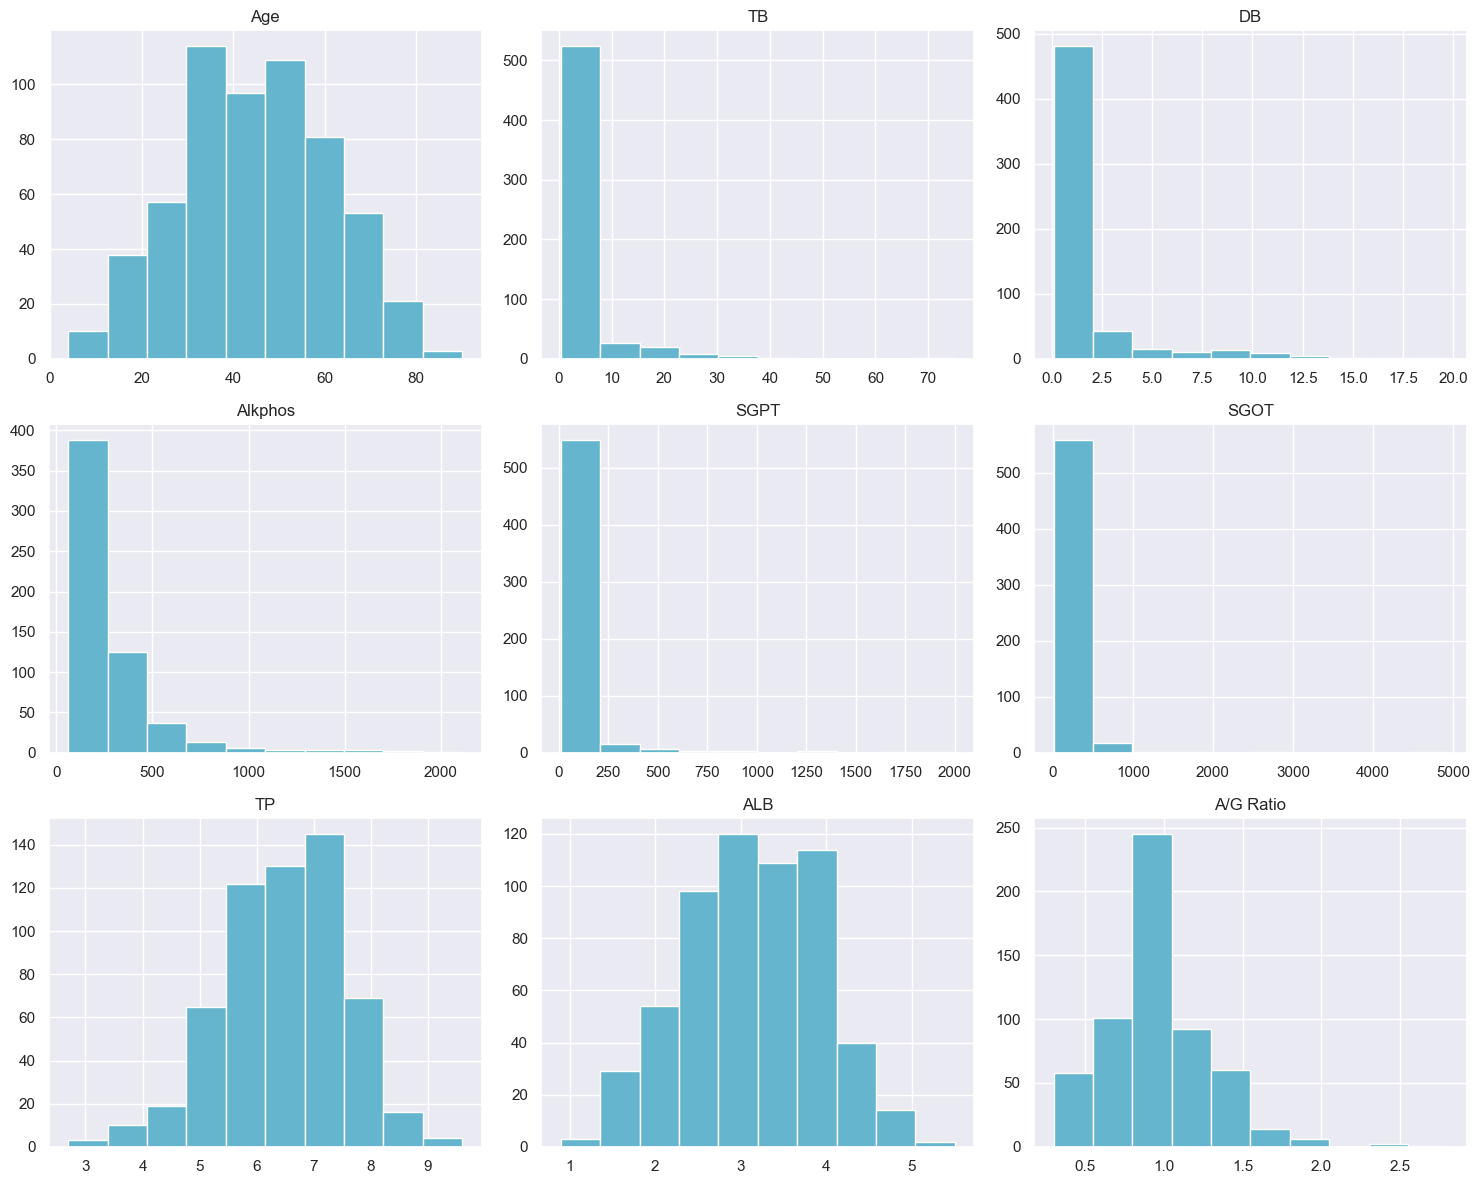

In [67]:
pltdf = df.copy(deep=True)
pltdf.drop(['Selector'], axis=1, inplace=True)
pltdf.hist(figsize=(15,12), color='c')
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.45, hspace=0.45)
plt.tight_layout()
plt.show()

# for column in df.drop(['Selector', 'Gender'], axis=1):
#     sns.histplot(x = df[column], palette="winter_r", kde=True)
#     plt.show()
    

In [68]:
# Identify Null values
df.isnull().sum()

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
SGPT         0
SGOT         0
TP           0
ALB          0
A/G Ratio    4
Selector     0
dtype: int64

In [69]:
# Replace Null values with the mean of the column
AGRatio_mean = df['A/G Ratio'].mean(numeric_only=True)
df.fillna(AGRatio_mean, inplace=True)

# Encode Gender
df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})

                Age    Gender        TB        DB   Alkphos      SGPT  \
Age        1.000000  0.056560  0.011763  0.007529  0.080425 -0.086883   
Gender     0.056560  1.000000  0.089291  0.100436 -0.027496  0.082332   
TB         0.011763  0.089291  1.000000  0.874618  0.206669  0.214065   
DB         0.007529  0.100436  0.874618  1.000000  0.234939  0.233894   
Alkphos    0.080425 -0.027496  0.206669  0.234939  1.000000  0.125680   
SGPT      -0.086883  0.082332  0.214065  0.233894  0.125680  1.000000   
SGOT      -0.019910  0.080336  0.237831  0.257544  0.167196  0.791966   
TP        -0.187461 -0.089121 -0.008099 -0.000139 -0.028514 -0.042518   
ALB       -0.265924 -0.093799 -0.222250 -0.228531 -0.165453 -0.029742   
A/G Ratio -0.216089 -0.003404 -0.206159 -0.200004 -0.233960 -0.002374   
Selector  -0.137351 -0.082416 -0.220208 -0.246046 -0.184866 -0.163416   

               SGOT        TP       ALB  A/G Ratio  Selector  
Age       -0.019910 -0.187461 -0.265924  -0.216089 -0.137351

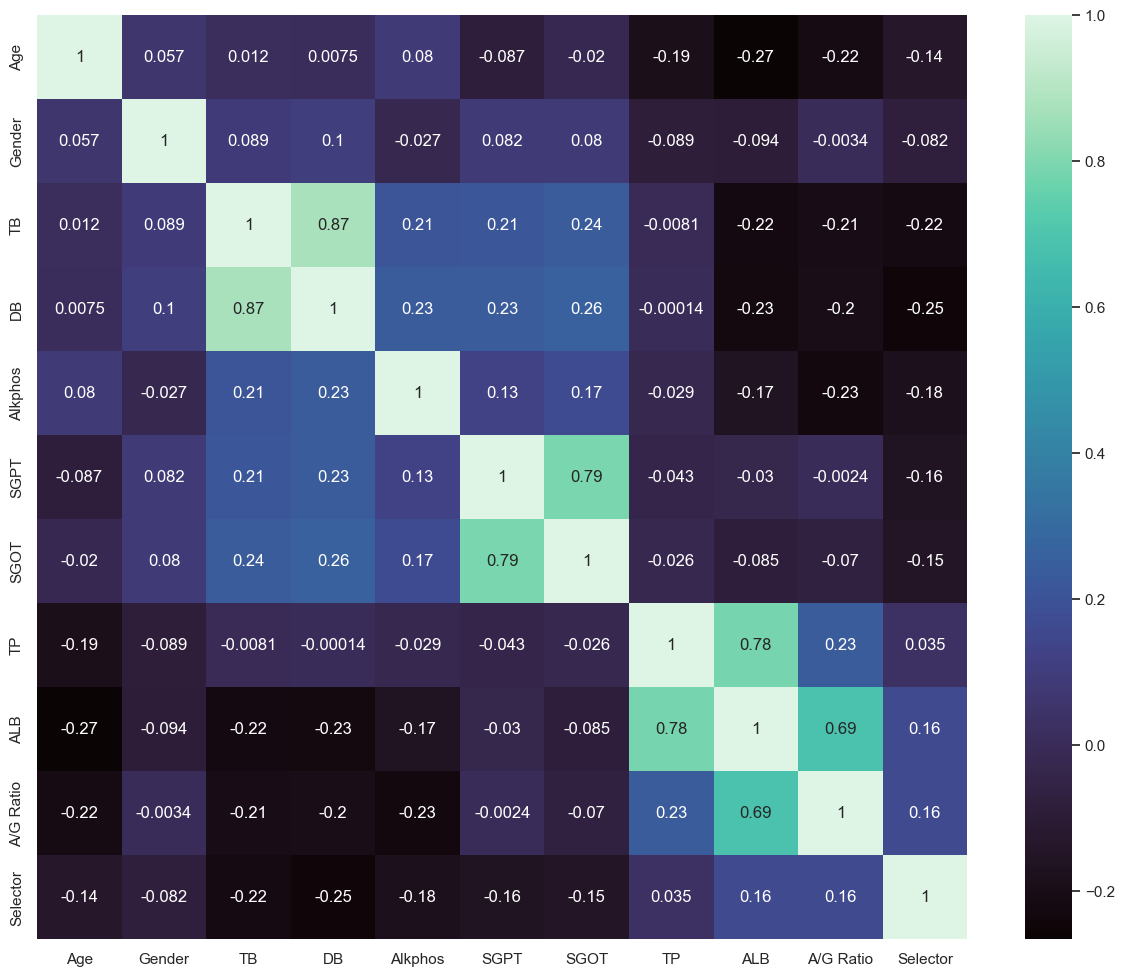

In [70]:
# Correlation of features
print(df.corr())

# Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, cmap='mako')
plt.show()

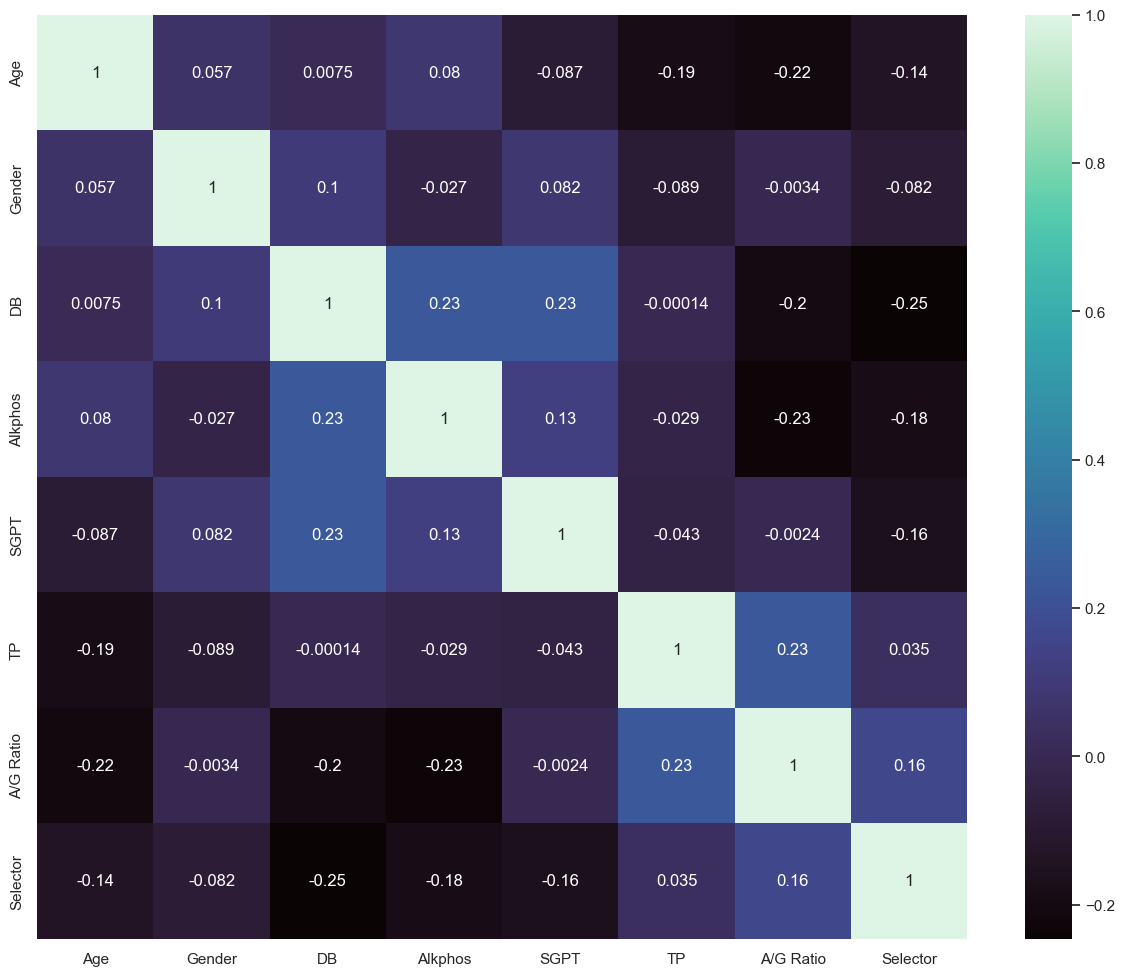

In [71]:
# Remove highly correlated features
df.drop(['TB','ALB','SGOT'], axis=1, inplace=True)

# Heatmap
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), annot=True, cmap='mako')
plt.show()

In [72]:
def Calc_IQR(column):
    """
    Calculates Interquartile Range for the removal of outliers

    Args:
        column (string): label of the current column of the DataFrame

    Returns:
        IQR (float): interquartile range
        upper (float): upper limit
        lower (float): lower limit
    """
    Q1 = np.percentile(df[column], 25, method='midpoint')
    Q3 = np.percentile(df[column], 75, method='midpoint')
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    return IQR, upper, lower

def Remove_Outliers(column):
    """
    Detects and removes outliers using IQR

    Args:
        column (string): label of the current column of the DataFrame
    """
    IQR, upper, lower = Calc_IQR(column)
    upper_array = np.where(df[column] >= upper)[0]
    lower_array = np.where(df[column] <= lower)[0]
    outliers_column = np.concatenate((upper_array, lower_array))
    df.drop(index=outliers_column, inplace=False)
    df.reset_index(inplace=True, drop=True)

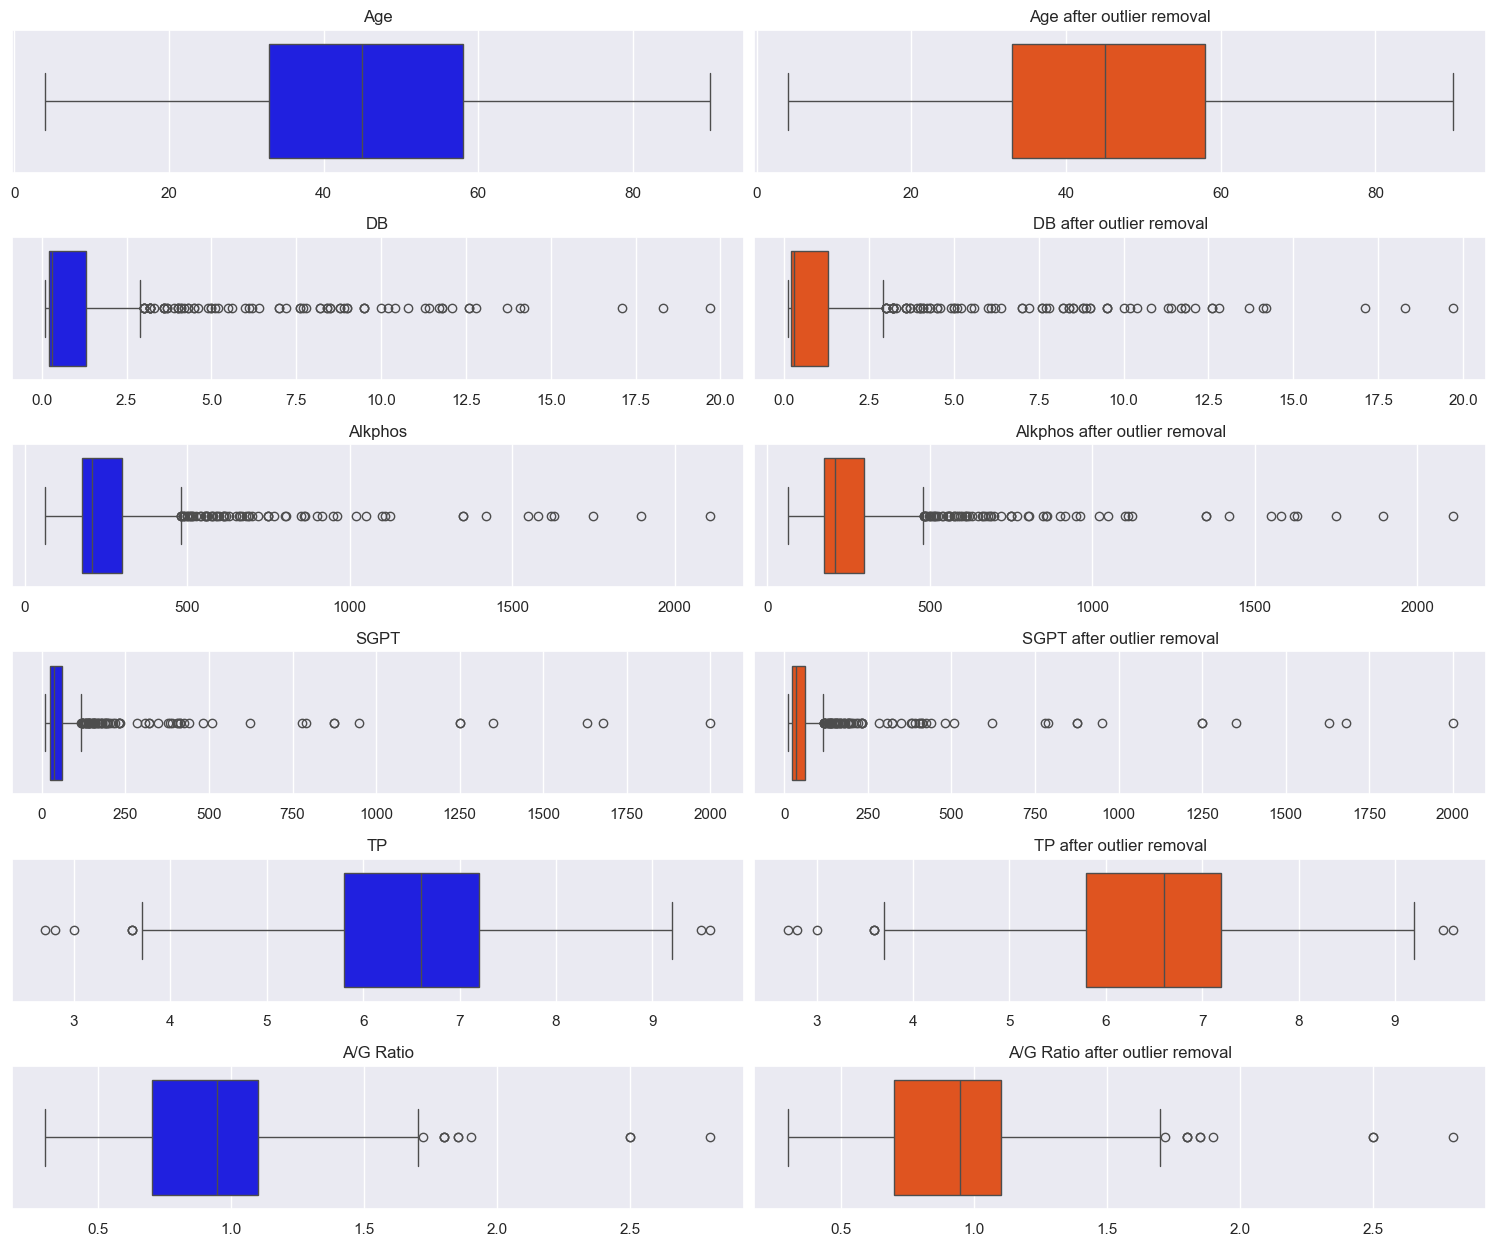

In [73]:
plt.figure(figsize=(15, 12.5))

for i, column in enumerate(df.drop(['Selector','Gender'], axis=1)):
    plt.subplot(6,2,i*2+1)
    sns.boxplot(df[column], color='blue', orient='h')
    plt.title(column)
    plt.xlabel('')

    Remove_Outliers(column)

    plt.subplot(6,2,i*2+2)
    sns.boxplot(df[column], color='orangered', orient='h')
    plt.title(column + ' after outlier removal')
    plt.xlabel('')

plt.tight_layout(pad=0.7, w_pad=0.5, h_pad=1.0)

In [74]:
# Scaling data using StandardScaler()
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()
df = scaler.fit_transform(df)

In [75]:
# Separate feature vectors(X) and labels(y)
y = np.transpose(df)[7]
X = np.delete(df, 7, 1)

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

In [76]:
# Convert to numpy arrays
X_train = np.asarray(X_train).astype(np.float64)
y_train = np.asarray(y_train).astype(np.float64)
X_val = np.asarray(X_val).astype(np.float64)
y_val = np.asarray(y_val).astype(np.float64)

input_shape = [X.shape[1]]

In [77]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
y_traintransformed = lab.fit_transform(y_train)
y_valtransformed = lab.fit_transform(y_val)

In [78]:
# Apply SMOTE to balance the classes
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_traintransformed)

print("Training set class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Training set class distribution after SMOTE:
0    307
1    307
Name: count, dtype: int64


In [79]:
def create_model():
    # Neural Network Configuration
    Neural_Network = keras.Sequential([keras.Input(shape=input_shape),
                                    keras.layers.Dense(units=64),
                                    keras.layers.Dropout(rate=0.2),
                                    keras.layers.Dense(units=32),
                                    keras.layers.Dropout(rate=0.2),
                                    keras.layers.Dense(units=16),
                                    keras.layers.Dense(units=1, activation='sigmoid')])
    optimizer = keras.optimizers.Adam(learning_rate=1e-3)
    Neural_Network.compile(optimizer=optimizer, loss='binary_crossentropy')
    # Neural_Network.summary()
    return Neural_Network

In [80]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_traintransformed)
# y_pred = rf_model.predict(X_val)
# print(classification_report(y_valtransformed, y_pred))

rand_clf = RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.75, min_samples_leaf=7, min_samples_split=3, n_estimators = 130)
rand_clf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.75,
                       min_samples_leaf=7, min_samples_split=3,
                       n_estimators=130)

In [81]:
# Support Vector Machine
def compute_val_error(val, prediction):
    return 1 - np.mean(prediction == val)

SVC_model = SVC(kernel='rbf')
SVC_model.fit(X_train, y_traintransformed)
pred_val_y = SVC_model.predict(X_val)
val_error = compute_val_error(y_valtransformed, pred_val_y)
print("Validation Error:", val_error)


Validation Error: 0.2534246575342466


In [82]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model.fit(X_train_balanced, y_train_balanced)
y_pred = lr_model.predict(X_val)
print("Train accuracy: " + str(accuracy_score(y_train_balanced, lr_model.predict(X_train_balanced))))
print("Validation accuracy: " + str(accuracy_score(y_valtransformed, y_pred)))
print(confusion_matrix(y_valtransformed, y_pred))

Train accuracy: 0.7263843648208469
Validation accuracy: 0.636986301369863
[[60 49]
 [ 4 33]]


In [83]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
print(accuracy_score(y_train, dtc.predict(X_train)))
dtc_acc = accuracy_score(y_valtransformed, dtc.predict(X_val))
print(dtc_acc)
print(confusion_matrix(y_valtransformed, dtc.predict(X_val)))
print(classification_report(y_valtransformed, dtc.predict(X_val)))

1.0
0.7123287671232876
[[84 25]
 [17 20]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       109
           1       0.44      0.54      0.49        37

    accuracy                           0.71       146
   macro avg       0.64      0.66      0.64       146
weighted avg       0.73      0.71      0.72       146



In [84]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()

parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.001, 0.1, 1, 10],
    'n_estimators': [100, 150, 180, 200]
}

grid_search_gbc = GridSearchCV(gbc, parameters, cv = 20, n_jobs = -1, verbose = 1)
grid_search_gbc.fit(X_train, y_train)
grid_search_gbc.best_params_
grid_search_gbc.best_score_
gbc = GradientBoostingClassifier(learning_rate=0.001, loss='exponential',n_estimators=100)
gbc.fit(X_train , y_train)
print(accuracy_score(y_train, gbc.predict(X_train)))
gbc_acc = accuracy_score(y_test, gbc.predict(X_test))
print(gbc_acc)
print(confusion_matrix(y_test, gbc.predict(X_test)))
print(classification_report(y_test, gbc.predict(X_test)))


NameError: name 'GridSearchCV' is not defined

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='binary:logistic', learning_rate = 0.001, max_depth = 100, n_estimators = 300)
xgb.fit(X_train, y_train)
print(accuracy_score(y_train, xgb.predict(X_train)))
xgb_acc = accuracy_score(y_valtransformed, xgb.predict(X_val))
print(xgb_acc)
print(confusion_matrix(y_valtransformed, xgb.predict(X_val)))
print(classification_report(y_valtransformed, xgb.predict(X_val)))

In [ ]:
models = pd.DataFrame({
    'Model':['Logistic Regreesion','KNN', 'SVC', 'Decision Tree Classifier', 'Random Forest Classifier', 'Gradient Boosting Classifer', 'XgBoost'],
    'Score':[100*round(lr_acc, 4), 100*round(knn_acc, 4), 100*round(svc_acc, 4), 100*round(dtc_acc, 4), 100*round(rand_clf_acc, 4), 100*round(gbc_acc, 4),100*round(xgb_acc, 4)]
})

In [ ]:
from sklearn import metrics
plt.figure(figsize=(8,5))
models = [
{
    'label': 'LR',
    'model': lr,
},
{
    'label': 'DT',
    'model': dtc,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]
for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred=model.predict(X_val) 
    fpr1, tpr1, thresholds = metrics.roc_curve(y_valtransformed, model.predict_proba(X_val)[:,1])
    auc = metrics.roc_auc_score(y_valtransformed,model.predict(X_val))
    plt.plot(fpr1, tpr1, label='%s - ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=12)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=12)
plt.title('ROC - Liver Disease Prediction', fontsize=12)
plt.legend(loc="lower right", fontsize=12)
plt.savefig("roc_liver.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
models = [
{
    'label': 'LR',
    'model': lr,
},
{
    'label': 'DT',
    'model': dtc,
},
{
    'label': 'SVM',
    'model': svc,
},
{
    'label': 'KNN',
    'model': knn,
},
{
    'label': 'XGBoost',
    'model': xgb,
},
{
    'label': 'RF',
    'model': rand_clf,
},
{
    'label': 'GBDT',
    'model': gbc,
}
]

means_roc = []
means_accuracy = [100*round(lr_acc,4), 100*round(dtc_acc,4), 100*round(svc_acc,4), 100*round(knn_acc,4), 100*round(xgb_acc,4), 
                  100*round(rand_clf_acc,4), 100*round(gbc_acc,4)]

for m in models:
    model = m['model'] 
    model.fit(X_train, y_train) 
    y_pred=model.predict(X_val) 
    fpr1, tpr1, thresholds = metrics.roc_curve(y_valtransformed, model.predict_proba(X_val)[:,1])
    auc = metrics.roc_auc_score(y_valtransformed,model.predict(X_val))
    auc = 100*round(auc,4)
    means_roc.append(auc)

print(means_accuracy)
print(means_roc)

# data to plot
n_groups = 7
means_accuracy = tuple(means_accuracy)
means_roc = tuple(means_roc)

# create plot
fig, ax = plt.subplots(figsize=(8,5))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, means_accuracy, bar_width,
alpha=opacity,
color='mediumpurple',
label='Accuracy (%)')

rects2 = plt.bar(index + bar_width, means_roc, bar_width,
alpha=opacity,
color='rebeccapurple',
label='ROC (%)')

plt.xlim([-1, 8])
plt.ylim([40, 76])

plt.title('Performance Evaluation - Liver Disease Prediction', fontsize=12)
plt.xticks(index, ('   LR', '   DT', '   SVM', '   KNN', 'XGBoost' , '   RF', '   GBDT'), rotation=40, ha='center', fontsize=12)
plt.legend(loc="upper right", fontsize=10)
plt.savefig("PE_liver.jpeg", format='jpeg', dpi=400, bbox_inches='tight')
plt.show()